
## captions are strictly mandatory: no captions no points. The discussion of what you do is the ultimate deliverable of each task

Captions need to describe: what is plotted and what is interesting about it


PLEASE REMEMBER: download your data in a reproducible way, seed your random functions if you need to use any, label your axes clearly, captions for each figure that explains what is shown, and what is noticeable about it, comment your code.






## respect coding standards
*The [following PEP8 rules](https://docs.google.com/document/d/1-XnKK4xRBA5FXOBa4p0Z4in7qfVyk4CutjSMEX-jpTQ/edit?usp=sharing) are now required*

Points will be taken off if they are violated

## problem statement

** An interesting and popular urban science question is "can we measure and predict energy use based on observables that are easily acquired". For example the urban observatory at CUSP can monitor lights: they are a relatively easy observable. All you need is a camera, and a pipeline to process your data. But how does the light coming from a window relate to the total energy consumption? We generally postulate that light is a proxy for occupancy, and that occupancy is a good predictor of energy consumption.**

** So let's test if the last link holds. If we have data on the _energy consumed by a building_ how well does that relate to the _number of units_ in the building?**

** Data on energy consumption can be found here for the city of NY https://data.cityofnewyork.us/Environment/Energy-and-Water-Data-Disclosure-for-Local-Law-84-/rgfe-8y2z  **

** Either obtain the data through the API or download the csv file, and move it to $PUIDATA**

** However this datasets does not have the number of units. We can find that in the [Pluto dataset](https://www1.nyc.gov/site/planning/data-maps/open-data/dwn-pluto-mappluto.page).**

** Reading in the Pluto data for manhattan, which will give me the number of units ber building   Manhattan/MNMapPLUTO.shp ** Note that you should keep all the files in the original MNMapPluto zipped folder (not just the .shp file) for geopandas to read the data in correctly.

In [89]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
%pylab inline
import zipfile
import urllib
import requests
import json
import io
import os
import sys
import shapely
import datetime
from fiona.crs import from_epsg
import pysal as ps
import statsmodels.formula.api as smf
import scipy
import os
import json

Populating the interactive namespace from numpy and matplotlib


# data acquisition

## download, move data to $PUIDATA, and read data in 
make sure you limit the PLUTO dataset to Manhattan, The entire NYC PLUTO dataset is huge!

In [11]:
download the energydata
!curl -O https://data.cityofnewyork.us/api/views/rgfe-8y2z/rows.csv?accessType=DOWNLOAD 

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 4329k    0 4329k    0     0  2571k      0 --:--:--  0:00:01 --:--:-- 2571k


In [13]:
os.system('mv rows.csv?accessType=DOWNLOAD Energy_and_Water_Data_Disclosure_for_Local_Law_84__2013_.csv')

0

In [14]:
os.system('mv Energy_and_Water_Data_Disclosure_for_Local_Law_84__2013_.csv $PUIDATA')

0

In [17]:
urllib.request.urlretrieve('https://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/mn_mappluto_18v1.zip',
                  os.getenv('PUIDATA')+'/MNMapPluto.zip')

('/nfshome/jz3309/PUIdata/MNMapPluto.zip',
 <http.client.HTTPMessage at 0x7f6d96f0e828>)

In [90]:
mnpluto = zipfile.ZipFile(os.getenv('PUIDATA')+'/MNMapPluto.zip')
mnpluto.extractall()

...download...

In [91]:
# load the buildinmg size as a geoDF and the local law 84 as a dtaframe
nrg = pd.read_csv(os.getenv("PUIDATA") + 
                  "/Energy_and_Water_Data_Disclosure_for_Local_Law_84__2013_.csv")

bsize = gp.GeoDataFrame.from_file(os.getenv("PUIDATA") + "/MNMapPLUTO.shp")

In [181]:
nrg.dtypes

Record Number                                                        int64
BBL                                                                float64
Co-reported BBL Status                                              object
BBLs Co-reported                                                    object
Reported NYC Building Identificaiton Numbers (BINs)                 object
Street Number                                                       object
Street Name                                                         object
Borough                                                             object
Postcode                                                           float64
DOF Benchmarking Submission Status                                  object
Site EUI(kBtu/ft2)                                                  object
Weather Normalized Site EUI(kBtu/ft2)                               object
Source EUI(kBtu/ft2)                                                object
Weather Normalized Source

In [182]:
bsize.dtypes

Borough        object
Block           int64
Lot             int64
CD              int64
CT2010         object
CB2010         object
SchoolDist     object
Council         int64
ZipCode         int64
FireComp       object
PolicePrct      int64
HealthCent      int64
HealthArea      int64
SanitBoro      object
SanitDistr     object
SanitSub       object
Address        object
ZoneDist1      object
ZoneDist2      object
ZoneDist3      object
ZoneDist4      object
Overlay1       object
Overlay2       object
SPDist1        object
SPDist2        object
SPDist3        object
LtdHeight      object
SplitZone      object
BldgClass      object
LandUse        object
               ...   
YearBuilt       int64
YearAlter1      int64
YearAlter2      int64
HistDist       object
Landmark       object
BuiltFAR      float64
ResidFAR      float64
CommFAR       float64
FacilFAR      float64
BoroCode        int64
BBL           float64
CondoNo         int64
Tract2010      object
XCoord          int64
YCoord    

## exploring the data a bit

As we discussed, coming up with a sensible model generally requires domain expertise. However, if the data you are investigating shows "obvious patterns", for example if two of the variable look like a line when plotted one against the other, then those patterns (correlations) may help you finding reasonable models for the data.

Explore your data, starting with a scatter matrix. 
A scatter matrix is a plot of all variables in your data against all other variables: 
each pair of variables is a subplot in the plot matrix. The diagonal line then would be a plot of a variable against itself, which is useless, so it is usually substituted by a histogram of that variable (or sometimes a KDE, which is basically a smooth histogram).

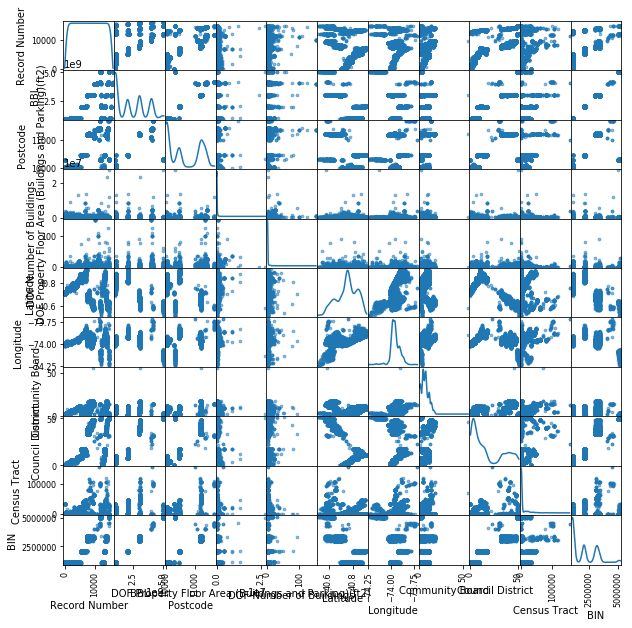

In [161]:
sfig = pd.scatter_matrix(nrg, s=30, figsize=(10, 10), diagonal='kde')

Figure 1: Above is a scatter matrix plotting of all variables in the energy and water data.some of the variables have correlation with others but because without data cleaning there are some variables have not been plotted.

This kind of plot shows correlations between variables, but it will also show me what can and cannot be plotted trivially in my dataset. Here only a few columns can be plotted: those that contain only numbers (and possibly NaN's), but most columns contain rows that cannot be converted to float (e.g. entries like 'See Primary BBL' in several rows for the energy dataframe 'Site EUI(kBtu/ft2) ' column) , so Pandas refuses to plot them, cause it does not know what to do with those entries. The columns I am interested in are in fact u'Site EUI(kBtu/ft2)' which is a measure of the energy consumed PER SQ FOOT by a building, and then the building area: for eg. u'Reported Property Floor Area (Building(s)) (ft²)'. Neither gets plotted: I need to remove all values that cannot convert to float in order to use the columns and convert them to float arrays and do math with them.

You can use pd.to_numeric() which is a function that transforms values to float (when possible). The default behavior of this function is to throw an error if it encounters a value that it cannot convert. That behavior can be modified with the "error" keyword, by setting it to "coerce". Please look at the function documentation to understand the syntax.

## data cleaning and aggregation 
### checking the content of the datasets


clean up columns I am not using: for my solution, I will keep  BBL, 'Site EUI(kBtu/ft2)', 'Reported Property Floor Area (Building(s)) (ft²)' from the energy dataframe, and BBL , UnitsTotal, UnitsRes, 'YearBuilt', and 'geometry' from the PLUTO geodaraframe

### remove what you do not need

In [92]:
nrg.columns
nrg = nrg[['BBL', 'Site EUI(kBtu/ft2)', 'Reported Property Floor Area (Building(s)) (ft²)']]

In [93]:
#bsize.columns.sort_values()
bsize = bsize[[ 'BBL' , 'UnitsTotal', 'UnitsRes', 'YearBuilt', 'geometry']]

In [94]:
#leave
nrg.head()

,BBL,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²)
0,1.000410e+09,NaN,918919
1,4.021460e+09,NaN,NaN
2,2.027620e+09,NaN,64200
3,1.006700e+09,NaN,NaN
4,2.048300e+09,NaN,50000


In [95]:
#leave
bsize.head()

,BBL,UnitsTotal,UnitsRes,YearBuilt,geometry
0,1.015450e+09,18,16,1920,"POLYGON ((997277.2344360352 221816.0936279297,..."
1,1.007238e+09,50,50,1914,"POLYGON ((984164.5626220703 211846.0704345703,..."
2,1.016800e+09,10,10,1910,"POLYGON ((1000742.195800781 227910.6640014648,..."
3,1.013850e+09,32,29,1928,"POLYGON ((994007.6885986328 219880.4284057617,..."
4,1.011970e+09,26,26,1900,"POLYGON ((992273.6849975586 224863.4904174805,..."


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8551022198>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f8550b48ba8>]], dtype=object)

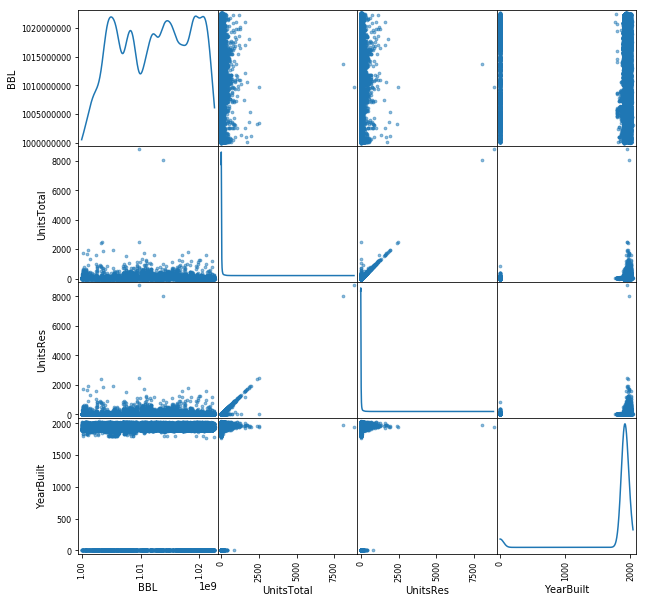

In [7]:
pd.scatter_matrix(bsize, s=30, figsize=(10, 10), diagonal='kde')

In [8]:
#leave (dont try this scatter matrix before cleaning the data, it will take a while)
#sfig = pd.scatter_matrix(bsize, s=30, figsize=(10, 10), diagonal='kde')

Figure 2: Above is a scatter matrix of all values in the manhattan map pluto data. There maybe some correlation between units Res and Units Total.

## converting  the relevant columns to numeric values and throwing away spurious entries

use pd.to_numeric() to convert strings to numeric values, remember the keyword "errors" which will be useful


In [96]:
len(bsize.columns)

5

In [97]:
nrg['Site EUI(kBtu/ft2)'] = pd.to_numeric(nrg['Site EUI(kBtu/ft2)'],errors = 'coerce')
nrg['Site EUI(kBtu/ft2)']

0          NaN
1          NaN
2          NaN
3          NaN
4          NaN
5          NaN
6          NaN
7          NaN
8          NaN
9          NaN
10         NaN
11         NaN
12         NaN
13         NaN
14         NaN
15         NaN
16       125.4
17         NaN
18         NaN
19         NaN
20         NaN
21         NaN
22         NaN
23         NaN
24         NaN
25         NaN
26         NaN
27         NaN
28         NaN
29         NaN
         ...  
16140      NaN
16141      NaN
16142      NaN
16143      NaN
16144      NaN
16145      NaN
16146      NaN
16147      NaN
16148      NaN
16149      NaN
16150      NaN
16151      NaN
16152      NaN
16153      NaN
16154      NaN
16155      NaN
16156      NaN
16157      NaN
16158      NaN
16159      NaN
16160      NaN
16161      NaN
16162      NaN
16163      NaN
16164      NaN
16165      NaN
16166      NaN
16167      NaN
16168      NaN
16169      NaN
Name: Site EUI(kBtu/ft2), dtype: float64

In [98]:
nrg['Reported Property Floor Area (Building(s)) (ft²)'] = pd.to_numeric(nrg['Reported Property Floor Area (Building(s)) (ft²)'],errors='coerce')
bsize['BBL'] = pd.to_numeric(bsize['BBL'],errors='coerce')

In [99]:
nrg['Site EUI(kBtu/ft2)'] = pd.to_numeric(nrg['Site EUI(kBtu/ft2)'], errors='coerce')
nrg['Property ft2'] = pd.to_numeric(
    nrg['Reported Property Floor Area (Building(s)) (ft²)'], errors='coerce')

In [100]:
##check that your conversion worked: e.g.
nrg['Site EUI(kBtu/ft2)'].astype(float)
bsize['BBL'].astype(float)
#[...] do this for all columns you care about in both datasets. 
#Nan's are ok, but you must not get an error when you try the conversion
#the Pluto data is much better at not using spurious entries for numerical value columns. 
#but check you can use the columns you want

#this should not return an error
#notice I can use the attribute notation to refer to columns in bsize, 
#cause the column names do not have spaces!


0        1.015450e+09
1        1.007238e+09
2        1.016800e+09
3        1.013850e+09
4        1.011970e+09
5        1.002360e+09
6        1.008370e+09
7        1.001960e+09
8        1.022240e+09
9        1.011270e+09
10       1.011650e+09
11       1.021740e+09
12       1.009120e+09
13       1.007920e+09
14       1.012110e+09
15       1.011240e+09
16       1.009040e+09
17       1.010090e+09
18       1.020620e+09
19       1.020630e+09
20       1.008940e+09
21       1.005728e+09
22       1.004400e+09
23       1.019470e+09
24       1.008830e+09
25       1.020810e+09
26       1.021610e+09
27       1.008570e+09
28       1.008830e+09
29       1.020410e+09
             ...     
42526    1.013428e+09
42527    1.019448e+09
42528    1.017298e+09
42529    1.018488e+09
42530    1.005008e+09
42531    1.020448e+09
42532    1.004518e+09
42533    1.020958e+09
42534    1.008498e+09
42535    1.017298e+09
42536    1.019108e+09
42537    1.016218e+09
42538    1.019448e+09
42539    1.005008e+09
42540    1

In [101]:
##check that your conversion worked: e.g.
print ("number of missing energy observations:", np.isnan(nrg['Site EUI(kBtu/ft2)'].astype(float)).sum())

number of missing energy observations: 4623


In [102]:
##check that your conversion worked: e.g.
print ("fraction of missing energy observations: %.2f"%(np.isnan(nrg['Site EUI(kBtu/ft2)'].astype(float)).sum() /
      len(nrg['Site EUI(kBtu/ft2)'])))

fraction of missing energy observations: 0.29


 ## merge the 2 datasets
 I can merge the dataframes on NYC Borough, Block, and Lot: BBL

In [103]:
nrg.head()

,BBL,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²),Property ft2
0,1.000410e+09,NaN,918919.0,918919.0
1,4.021460e+09,NaN,NaN,NaN
2,2.027620e+09,NaN,64200.0,64200.0
3,1.006700e+09,NaN,NaN,NaN
4,2.048300e+09,NaN,50000.0,50000.0


In [104]:
#leave
#merge in a geodataframe for mapping, and if you want in a regular DF for analysis (more portable)


bblnrgdata = pd.merge(nrg,bsize,on='BBL').dropna()
bblnrgdataGPD = gpd.GeoDataFrame(bblnrgdata,geometry='geometry')

In [105]:
bblnrgdata.head()

,BBL,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²),Property ft2,UnitsTotal,UnitsRes,YearBuilt,geometry
2,1.013110e+09,125.4,330000.0,330000.0,56,0,1977,"POLYGON ((993141.1744384766 216172.3948364258,..."
10,1.010140e+09,154.9,841709.0,841709.0,2,0,1999,"POLYGON ((987726.6307983398 214846.9885864258,..."
15,1.007660e+09,122.3,59468.0,59468.0,8,0,1912,"POLYGON ((984350.5375976562 209226.3930053711,..."
16,1.008150e+09,117.0,364000.0,364000.0,64,0,1954,"POLYGON ((988118.5700073242 213939.774597168, ..."
18,1.005050e+09,82.1,235370.0,235370.0,24,0,1926,"POLYGON ((982849.6038208008 203886.2427978516,..."


# Plot the data as a choropleth for the 2 quantities of interest: number of units and energy consumed energy

In [106]:
bblnrgdataGPD.head()

,BBL,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²),Property ft2,UnitsTotal,UnitsRes,YearBuilt,geometry
2,1.013110e+09,125.4,330000.0,330000.0,56,0,1977,"POLYGON ((993141.1744384766 216172.3948364258,..."
10,1.010140e+09,154.9,841709.0,841709.0,2,0,1999,"POLYGON ((987726.6307983398 214846.9885864258,..."
15,1.007660e+09,122.3,59468.0,59468.0,8,0,1912,"POLYGON ((984350.5375976562 209226.3930053711,..."
16,1.008150e+09,117.0,364000.0,364000.0,64,0,1954,"POLYGON ((988118.5700073242 213939.774597168, ..."
18,1.005050e+09,82.1,235370.0,235370.0,24,0,1926,"POLYGON ((982849.6038208008 203886.2427978516,..."


In [107]:
bblnrgdataGPD.dtypes

BBL                                                 float64
Site EUI(kBtu/ft2)                                  float64
Reported Property Floor Area (Building(s)) (ft²)    float64
Property ft2                                        float64
UnitsTotal                                            int64
UnitsRes                                              int64
YearBuilt                                             int64
geometry                                             object
dtype: object

In [108]:
bblnrgdataGPD['logarea'] = np.log10(bblnrgdataGPD['Reported Property Floor Area (Building(s)) (ft²)'])
bblnrgdataGPD['lognrg'] = np.log10(bblnrgdataGPD[ 'Reported Property Floor Area (Building(s)) (ft²)']*bblnrgdata['Site EUI(kBtu/ft2)'])
bblnrgdataGPD['lognrg']

2        7.616811
10       8.115213
15       6.861710
16       7.629287
18       7.286094
19       6.950549
20       6.811909
21       6.860458
22       7.424460
23       6.919769
24      10.415995
25       7.653890
26       5.947502
28       6.827491
29       7.196269
30       6.919324
31       7.881446
32       7.947315
33       6.862490
34       6.732507
35       6.820855
36       6.234376
37       6.687587
39       6.561483
40       8.343911
41       7.626926
42       6.911172
43       6.657050
44       7.102234
45       8.350403
          ...    
5706     7.226674
5708     6.863740
5709     6.728326
5711     6.409035
5712     7.226957
5714     6.811434
5715     6.727395
5716     6.748242
5717     7.104999
5719     6.855901
5722     6.757815
5724     6.884657
5727     5.021189
5731     7.057400
5732     5.169806
5733     5.430269
5734     6.716678
5735     5.132516
5736     6.696968
5738     7.633503
5739     9.633120
5740     6.942216
5741     6.485208
5742     6.685983
5743     6

Text(0.5,1,'Energy consumed')

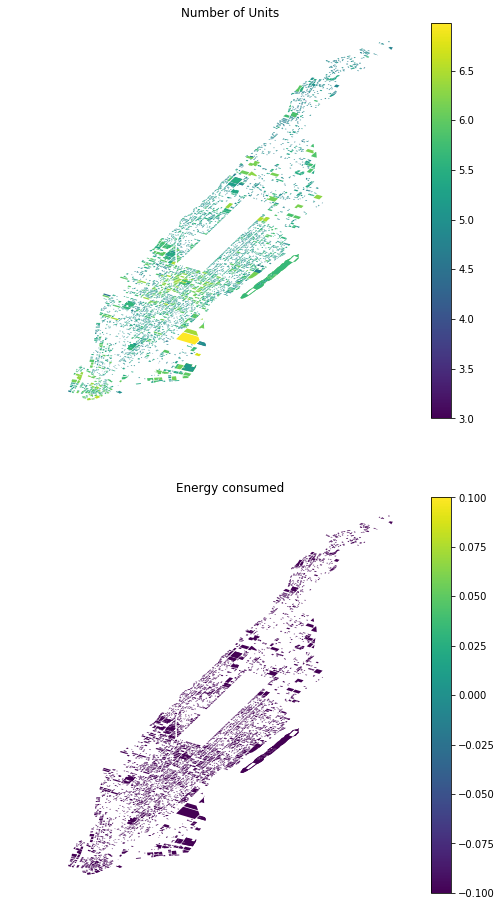

In [221]:
fig = plt.figure(figsize(8,16))
ax1= fig.add_subplot(211)
bblnrgdataGPD.plot(column='logarea',ax=ax1,legend=True)
ax1.axis('off')
ax1.set_title('Number of Units')

ax2 = fig.add_subplot(212)
bblnrgdataGPD.plot(column='lognrg',ax=ax2,legend=True)
ax2.axis('off')
ax2.set_title('Energy consumed')

In [219]:
#bblnrgdataGPD['logarea'] = ...
#bblnrgdataGPD['lognrg'] = ...

...

Ellipsis

Figure 3: Choroplethes above are the log of total units and energy consumed in manhattan.For the two plots, yellow is lower and dark blue is higher values. Number of units in Manhattan is generally high. there is a outlier on the southeast.Log of energy consumed is generally lower than -0.05.

# feature engineering
the question was not if larger buildings consume more energy, its if occupancy increases consumption, so we want to model *total energy* with *total units*.
Create a total energy column from the columns you have.
Plot a column vs the other. You will be unable to see most of the points (as in the plot below). Make another plot "zooming in" to remove some outliers from the view and see if this reveals some patterns.

In [109]:
## multiplying area by energy/area to get total energy per building
bblnrgdata['nrg'] = bblnrgdata[\
    'Reported Property Floor Area (Building(s)) (ft²)'].astype(float) *\
                bblnrgdata['Site EUI(kBtu/ft2)'].astype(float)

Text(0,0.5,'Number of total units in building')

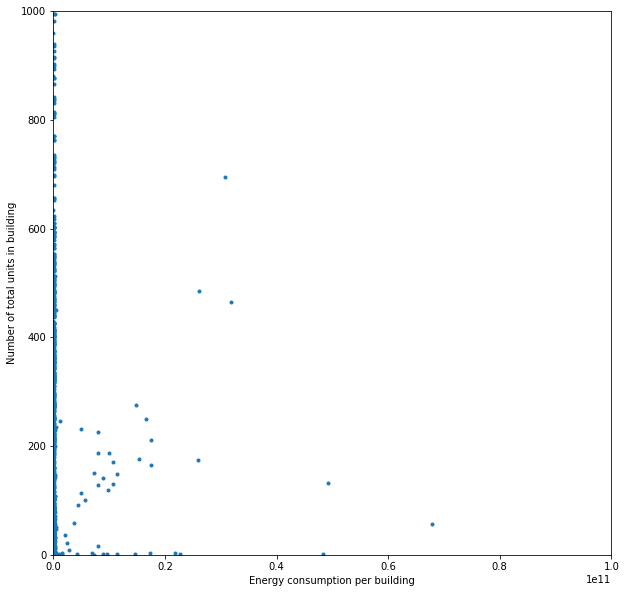

In [110]:
plt.figure(figsize=(10,10))
plt.plot(bblnrgdata['nrg'],bblnrgdata['UnitsTotal'],'.')
plt.xlim(0,1e11)
plt.ylim(0,1000)
plt.xlabel('Energy consumption per building')
plt.ylabel('Number of total units in building')

Figure 4: Figure above shows the number of units against energy consumpition per building. It's hard to see possible correlation between two variables.

In [111]:
print('Maximun building energy value %s'%bblnrgdata['nrg'].max())
print('Minimum building energy value %s'%bblnrgdata['nrg'].min())

Maximun building energy value 350145188000.0
Minimum building energy value 0.0


# The magic of log scales!
**Please read the following vcarefully! this is the only opportunity I have to discuss this with you this year. **

Very often in science we will visualize data in log scale and model log data instead of the natural dataset (generally in log10).

In in log10 every order of magnitude is separate by a unit: log10(10) = 1, log10(100) = 2, log10(100000)=5 (basically log10 gives you the number of 0's in its argument, or the *order of magnitude*)





Text(0,0.5,'$log_{10}$(x)')

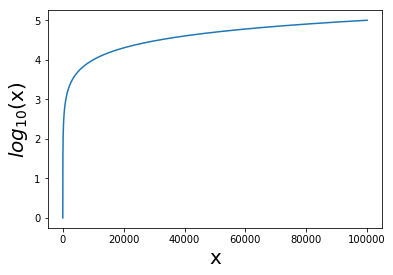

In [112]:
plt.figure(figsize=(6,4))
plt.plot(np.arange(100000), np.log10(np.arange(100000)), '-')
plt.xlabel("x", fontsize=20)
plt.ylabel(r"$log_{10}$(x)", fontsize=20)

The logarithm is a monotonic function : wherever its argument grows the function grows, wherever its argument decrease its log decrease. It's a function that grows fast when the argument is small and slowly when the argument is large, so it compresses the scale. 

Another property of the logarithm is that if the relationship between data is a power law (y = x^a) then the relationship between the log of the variables is linear! And we know that modeling things with linear models is easy!

	log_10(x^y) = y ∙ log_10(x)
    
And since power laws are very common in nature we often model with power laws, or with inear relationships in log space.

# Plot both NRG vs Units total and Units total vs NRG, both in log space

Surely there is a right way to think about which one is the independent and the dependent variable in this problem: do we think energy consumption causes occupancy or occupancy causes consumption?

You are going to have to limit the axis values or you will not see anything: 

    energy between (1000,1e10)

    units between (1,1000)

You can cut the axis to visualize the data like this, **but you will need to cut the data to remove datapoint outside of this range when you model to get a good model.**

to visualize the data in log scale you can use the dataframe plotting method with the argument 

    loglog=True


In [113]:
bblnrgdata2 = bblnrgdata[(bblnrgdata.nrg > 1000) * (bblnrgdata.UnitsTotal>1) * (bblnrgdata.UnitsTotal<1000)]

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/pandas/computation/expressions.py:181: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  unsupported[op_str]))


Text(0,0.5,'Energy consumption per building (kBtu)')

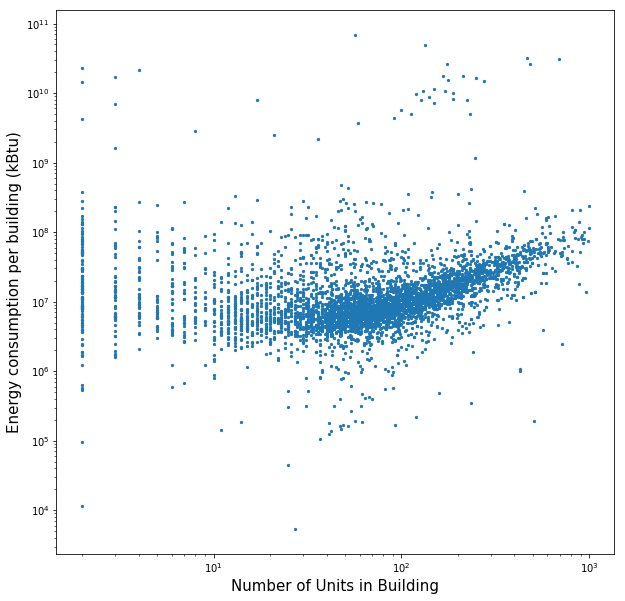

In [114]:
plt.figure(figsize(10,10))
bblnrgdata2.plot(x='UnitsTotal',y='nrg',loglog=True,marker = '.',kind='scatter')
plt.xlabel("Number of Units in Building", fontsize=15)
plt.ylabel("Energy consumption per building (kBtu)", fontsize=15)

Figure 6 : Figure above shows the energy consumption against total units in log space. It is possibly a positive correlation between energy consumption and total units.

Text(0.5,0,'Energy consumption per building (kBtu)')

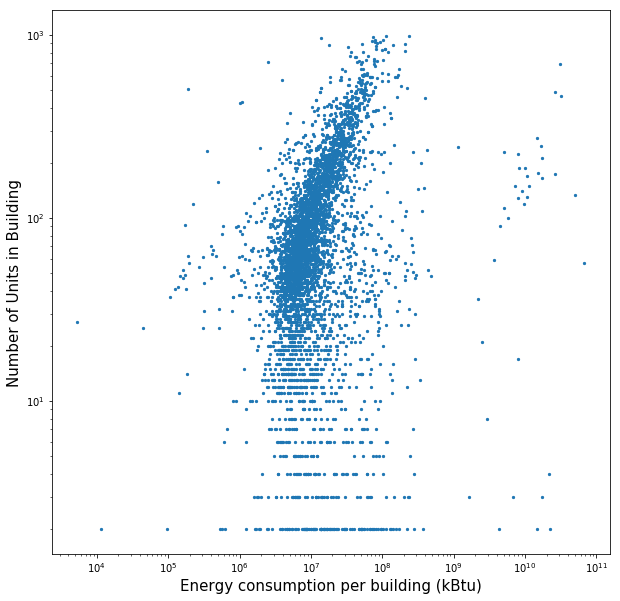

In [115]:
plt.figure(figsize(10,10))
bblnrgdata2.plot(x='nrg',y='UnitsTotal',loglog=True,marker = '.',kind='scatter')
plt.ylabel("Number of Units in Building", fontsize=15)
plt.xlabel("Energy consumption per building (kBtu)", fontsize=15)

Figure 7 : Figure above shows the total units against energy consumption per building.There is possibly a possitive correlaiton between number of units in building and energy consumption per building.

# Fit the data with a line in log space:  

**make sure you print the summary and plot the data and the model**

## Model NRG as a linear function of number of units in the building 
Ciertainly there is a right way to think about this: which is the *independent* and the *dependent* variable? which do we think causes which? do units "cause"energy consumption or vice versa? please answer below

**answer** I think it should be that the units cause energy consumption.

However, indulge me and try both models: models (nrg vs units total & units total vs nrg). 

- create the models with statsmodels
- print the model summary
- plot the data and the fit
- Check and comment on how the following model diagnostics change: 
        R^2 and LogLikelihood
        
(remember to use only the data in the appropriate range, see the previous step)

### Units vs Energy

### Energy against Units

# Second degree polynomial fit

model the data with a slightly more complex model: 
    
    y = ax*x + bx + c, 

instead of 
        
    y = bx + c
    
**make sure you print the summary and plot the data and the model**


In [33]:
bblnrgdataCut = bblnrgdata2
bblnrgdataCut.head()

,BBL,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²),Property ft2,UnitsTotal,UnitsRes,YearBuilt,geometry,logarea,lognrg,nrg
2,1.013110e+09,125.4,330000.0,330000.0,56,0,1977,"POLYGON ((993141.1744384766 216172.3948364258,...",5.518514,7.616811,41382000.0
10,1.010140e+09,154.9,841709.0,841709.0,2,0,1999,"POLYGON ((987726.6307983398 214846.9885864258,...",5.925162,8.115213,130380724.1
15,1.007660e+09,122.3,59468.0,59468.0,8,0,1912,"POLYGON ((984350.5375976562 209226.3930053711,...",4.774283,6.861710,7272936.4
16,1.008150e+09,117.0,364000.0,364000.0,64,0,1954,"POLYGON ((988118.5700073242 213939.774597168, ...",5.561101,7.629287,42588000.0
18,1.005050e+09,82.1,235370.0,235370.0,24,0,1926,"POLYGON ((982849.6038208008 203886.2427978516,...",5.371751,7.286094,19323877.0


In [34]:
#I find the easiest way to use the formula package is to use a dataframe 
#with the quantities that are not linear already calculated

# you can do it whichever way is easy for you
bblnrgdataCut['logNrg']  = np.log10(bblnrgdataCut['nrg'])
bblnrgdataCut['logUnits']  = np.log10(bblnrgdataCut['UnitsTotal'])


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [86]:
OLS1 = smf.ols(formula= 'logNrg~logUnits',data=bblnrgdataCut).fit()
OLS1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 logNrg   R-squared:                       0.047
Model:                            OLS   Adj. R-squared:                  0.047
Method:                 Least Squares   F-statistic:                     230.1
Date:                Tue, 27 Nov 2018   Prob (F-statistic):           9.01e-51
Time:                        20:03:11   Log-Likelihood:                -3290.4
No. Observations:                4642   AIC:                             6585.
Df Residuals:                    4640   BIC:                             6598.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      6.6693      0.026    257.585      0.000         6.619     6.720
logUnits       0.2112      0.014     15.170      0.000         0.184     0.238
==============================================================================
Omnibus:                     2184.463   Durbin-Watson:                   1.622
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            30502.285
Skew:                           1.883   Prob(JB):                         0.00
Kurtosis:                      14.980   Cond. No.                         8.48
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(0,0.5,'Energy Consumption')

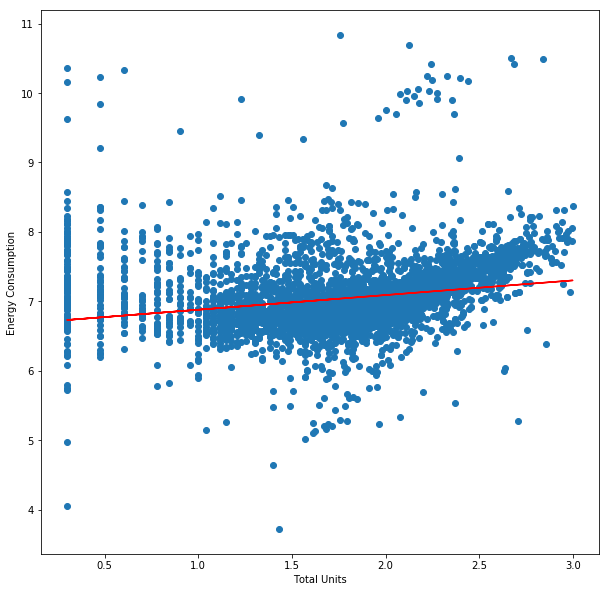

In [36]:
plt.figure(figsize=(10,10))
plt.scatter(bblnrgdataCut['logUnits'],bblnrgdataCut['logNrg'],label='o')
plt.plot(bblnrgdataCut.logUnits,OLS1.predict(),'r')
plt.xlabel('Total Units')
plt.ylabel('Energy Consumption')

Figure 8: The plot shows the log of total energy ocnsumption against the log of total number of total units. The red line is the fitted line. From the plot, there is a positive correlaiton between the energy consumption with total units.

## Energy VS Units

In [37]:
OLS2 = smf.ols(formula='logUnits~logNrg',data=bblnrgdataCut).fit()
OLS2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               logUnits   R-squared:                       0.047
Model:                            OLS   Adj. R-squared:                  0.047
Method:                 Least Squares   F-statistic:                     230.1
Date:                Tue, 27 Nov 2018   Prob (F-statistic):           9.01e-51
Time:                        18:15:08   Log-Likelihood:                -3425.3
No. Observations:                4642   AIC:                             6855.
Df Residuals:                    4640   BIC:                             6868.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      0.2095      0.104      2.010      0.044         0.005     0.414
logNrg         0.2238      0.015     15.170      0.000         0.195     0.253
==============================================================================
Omnibus:                      783.842   Durbin-Watson:                   1.460
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1367.186
Skew:                          -1.088   Prob(JB):                    1.32e-297
Kurtosis:                       4.527   Cond. No.                         101.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(0,0.5,'Total Units')

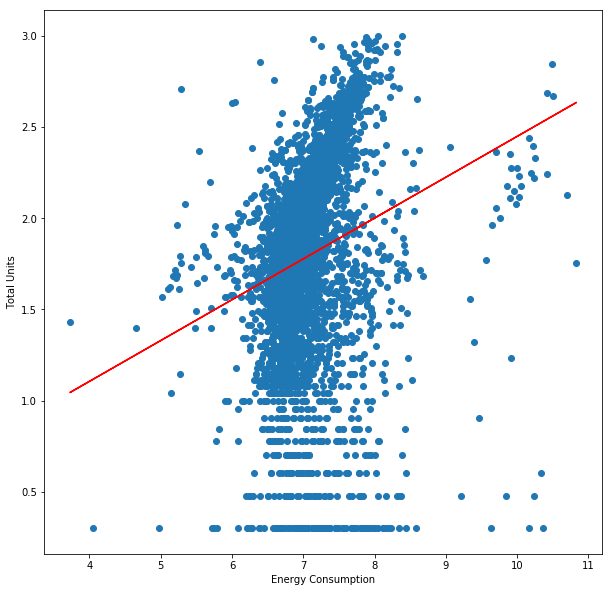

In [38]:
plt.figure(figsize=(10,10))
plt.scatter(bblnrgdataCut['logNrg'],bblnrgdataCut['logUnits'],label='o')
plt.plot(bblnrgdataCut['logNrg'],OLS2.predict(),'r')
plt.xlabel('Energy Consumption')
plt.ylabel('Total Units')

Figure 8.2: Above is the plot about the log of total bumebr of units agnainst the log of energy consumption with a fitted line. The R^2 does not change.

## Polynomial

In [68]:
OLS3 = smf.ols("logNrg ~ logUnits + I(logUnits**2)", data = bblnrgdataCut).fit()

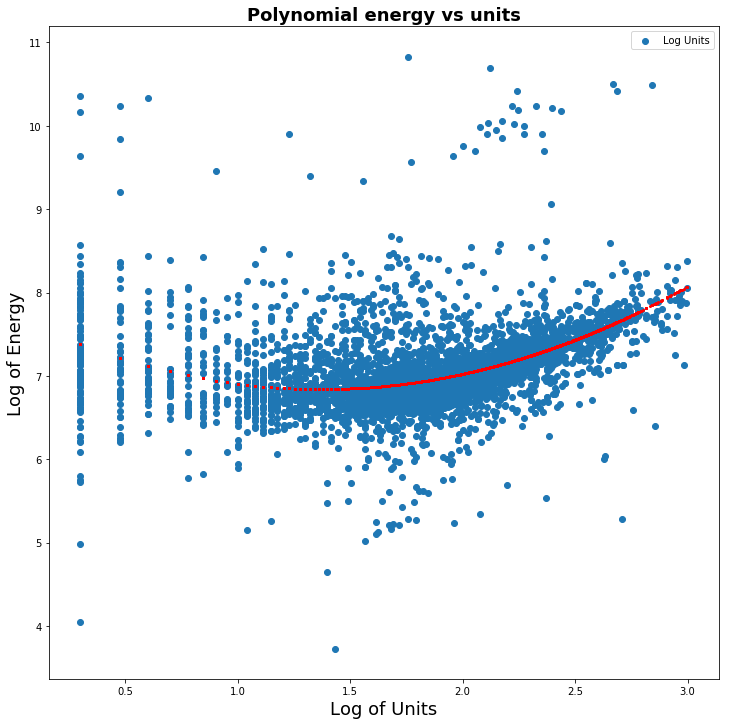

In [116]:
plt.figure(figsize = [12, 12])
plt.scatter(bblnrgdataCut['logUnits'], bblnrgdataCut['logNrg'], label='Log Units')
plt.plot(bblnrgdataCut['logUnits'], OLS3.predict() ,'ro', markersize = 2)
plt.xlabel('Log of Units', fontsize = 18)
plt.ylabel('Log of Energy', fontsize = 18)
plt.title('Polynomial energy vs units', weight = 'bold', fontsize = 18)
plt.legend()
plt.show()

Figure9: The figure above shows the polynomial fitting log of energy vs the log of units. The polynomial fits better , there is a positive correlation between log of energy and log of units.

# calculate the chi square and likelihood of your model

## Define a chisquare function

#leave
def chi2(data, model, errors = None):
    '''Calculates the chi sq given data, model and errors
    Arguments:
    data: series of datapoints (endogenous variable)
    model: series of predicted values corresponding to the observed data
    errors: serie of errors (optional). 
    If errors are not passes all errors are set to 1
    '''
    
    

In [135]:

def chi2(data, model, errors = None):
    '''Calculates the chi sq given data, model and errors
    Arguments:
    data: series of datapoints (endogenous variable)
    model: series of predicted values corresponding to the observed data
    errors: serie of errors (optional). 
    If errors are not passes all errors are set to 1
    '''
    if errors is None:
        errors = np.ones_like(data)
    if data.shape == model.shape and data.shape == errors.shape:
        return (((data - model)**2) / errors**2).sum()


## Define and calculate errors

Assume Poisson statistics and calculate the errors accordingly. Remember that you have used 2 quantities combined linearly to calculate the energy (your *dependent* variable) , so the errors combine in quadrature!

    Total Error = sqrt(error1^2 + error2^2)
    
Your *independent* variable has uncertainty also! assume it is also Poissonian

** propagation of errors on the log:**
https://en.wikipedia.org/wiki/Propagation_of_uncertainty#Linear_combinations

$f=a\log _{10}(A)$

$\sigma _{f}\approx \left(a{\frac {\sigma _{A}}{A\ln(10)}}\right)$

In [136]:
errorsnrg = np.sqrt((bblnrgdataCut['Property ft2'])**2 +(bblnrgdataCut['Site EUI(kBtu/ft2)']**2))
errorsunits = np.sqrt(bblnrgdataCut.UnitsTotal)

In [137]:
errorsInLogNrg = np.abs(errorsnrg / bblnrgdataCut.nrg / np.log(10))
errorsInLogUnits = np.abs(errorsunits / bblnrgdataCut.UnitsTotal / np.log(10))

bblnrgdataCut['errorsnrg'] = errorsInLogNrg
bblnrgdataCut['errorsunits'] = errorsInLogUnits

In [ ]:
#propagation of errors on the log


## Make 3 plots: one with x errors, one with y errors, one with x and y errors. 

with pylab you can do it with pl.errorbar(x, y, xerr=xerror, yerr=yerror)

The largest error bar is for


,BBL,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²),Property ft2,UnitsTotal,UnitsRes,YearBuilt,geometry,logarea,lognrg,nrg,logNrg,logUnits,errorsnrg,errorsunits
3795,1.019900e+09,0.1,53440.0,53440.0,27,27,1909,"POLYGON ((994066.3934326172 234073.4490356445,...",4.727866,3.727866,5344.0,3.727866,1.431364,4.342945,0.08358


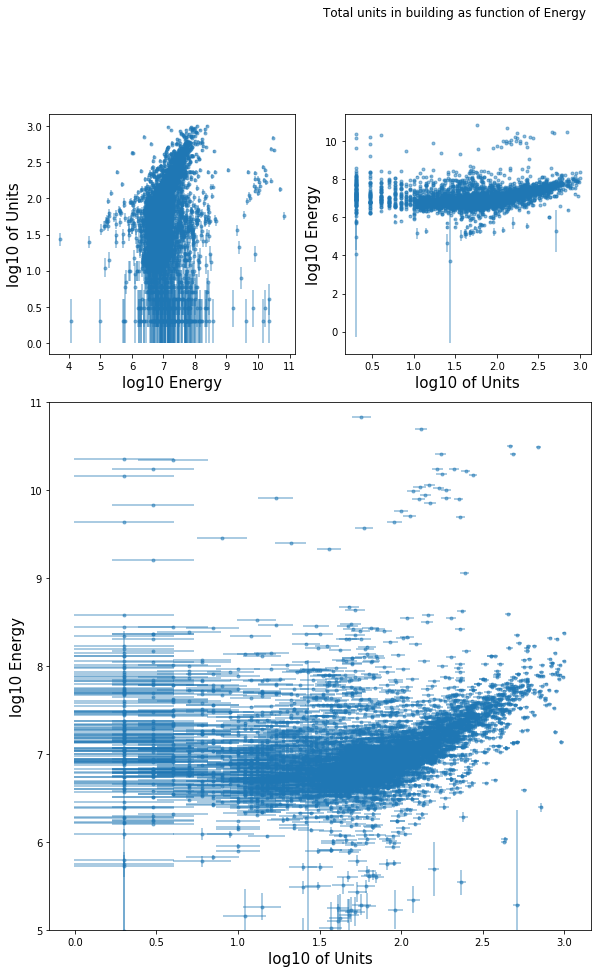

In [365]:
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec
#I could also include errors for number of units
fig2 = plt.figure(figsize=(15,15))

gs1 = gridspec.GridSpec(3, 3, fig2)
gs1.update(left=0.68, right=0.68, wspace=0.2)


ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=1)
ax1.errorbar(bblnrgdataCut['logNrg'],bblnrgdataCut['logUnits'],
            yerr=bblnrgdataCut.errorsunits, fmt='.',
            alpha=0.5)
ax1.set_ylabel("log10 of Units", fontsize=15)
ax1.set_xlabel("log10 Energy", fontsize=15)
plt.suptitle("Total units in building as function of Energy")


ax2 = plt.subplot2grid((3, 3), (0, 1), colspan=1)
ax2.errorbar(bblnrgdataCut.logUnits, bblnrgdataCut.logNrg, 
            yerr=bblnrgdataCut.errorsnrg, fmt='.',
            alpha=0.5)
ax2.set_xlabel("log10 of Units", fontsize=15)
ax2.set_ylabel("log10 Energy", fontsize=15)

ax4 = plt.subplot2grid((3, 3), (1, 0), colspan=2, rowspan=2)
ax4.errorbar(bblnrgdataCut.logUnits, bblnrgdataCut.logNrg, 
            yerr=bblnrgdataCut.errorsnrg,
           xerr=bblnrgdataCut.errorsunits, alpha=0.5, fmt='.')
ax4.set_xlabel("log10 of Units", fontsize=15)
ax4.set_ylabel("log10 Energy", fontsize=15)
ax4.set_ylim(5,11)

print ("The largest error bar is for")
bblnrgdataCut[bblnrgdataCut.errorsnrg == bblnrgdataCut.errorsnrg.max()]


Figure 7: The same as Figure 5 and 6, but with errorbars. In the top panel the errors on the Units in the building are plotted, in the bottom panels the errors on the energy are plotted, but they are too small to see,  and both on the right side panel. The bottom right panel is a zoom-in of the bottom left panel. Errors are measured by assuming Poisson statistics at the measurement level for energy per square foot, squarefootage, and for the number of units, and propagate properly to the log space. Notice that we do not know what the units of energy really represent: the Poisson statitics should be applied to the measured counts, but the enrgy consumption is a continuous variable, only discretized by the act of measuring it. 

IMPORTANT! errors as the square root of the measurement (Poisson statistics) are ONLY meaningful when you are potting dimensionless quantoities! here it is preposterous to assume that the errors are the square root of the measurement. WHY? because then if I express my energy by sq meter, instead of sq feet, I get a different error on the measurement for the same measurement - which makes no sense! However, in this case, I am not using the errors to create the model (no WLS for example) so this error allows me to compare uncertainty on the datapoints. Even if the errors are different, under linear transformations (changes of units for example) the relationship between errors on 2 datapoints will be preserved. 

Notice: No points are taken off if other errors are used, including the sqrt of the log energy, and the correct errors propagation in the log on errors calculated, however, as the sqrt of the tot energy per building, but the errors are in the measured quantities, so this is the proper way to obtain them. In addition the units of energy are extremely large, thus the errors in percentage on the energy are extremely small. These errors are likely to be underestmated due to our ignorance of the details of the experiment.

## Add the errors and calculate the chi square


### calculate the degrees of freedom of this model

In [119]:
OLS1.params

Intercept    6.669342
logUnits     0.211154
dtype: float64

In [120]:
#degrees of freedom: number of observations - number of model parameters
# note: these are reported as dof of the residuals in the statsmodels fit summary, but jsut to make sure let's calculate them
dof = 4641
print ("degrees of freedom:" , dof)

degrees of freedom: 4641


In [124]:
print ("Units vs Energy residuals (no errors include): %.2f"%\
       (chi2(np.log10(bblnrgdataCut.UnitsTotal), OLS1.predict()) / 
        float(dof)))

print ("Units vs Energy chi square per DOF w independent variable error only: %.2f"%\
       (chi2(np.log10(bblnrgdataCut.UnitsTotal), OLS1.predict(), 
            errors = bblnrgdataCut.errorsnrg) / dof))

print ("Units vs Energy chi square per DOF : %.2f"%\
       (chi2(np.log10(bblnrgdataCut.UnitsTotal), OLS1.predict(), 
            errors = np.sqrt(bblnrgdataCut.errorsnrg**2 + 
                             bblnrgdataCut.errorsunits**2))  / dof))

Units vs Energy residuals (no errors include): 27.84
Units vs Energy chi square per DOF w independent variable error only: 3163381508.49
Units vs Energy chi square per DOF : 13173.33


In [125]:
print ("Energy vs Units residuals (no errors include): %.2f"%\
       (chi2(np.log10(bblnrgdataCut.nrg), OLS2.predict()) / dof))

print ("Energy vs Units chi square per DOF w independent variable error only: %.2f"%\
       (chi2(np.log10(bblnrgdataCut.nrg), OLS2.predict(), 
            errors = bblnrgdataCut.errorsnrg) / dof))

print ("Energy vs Units chi square per DOF : %.2f"%\
       (chi2(np.log10(bblnrgdataCut.nrg), OLS2.predict(), 
            errors = np.sqrt(bblnrgdataCut.errorsnrg**2 + 
                             bblnrgdataCut.errorsunits**2))  / dof))

Energy vs Units residuals (no errors include): 27.83
Energy vs Units chi square per DOF w independent variable error only: 6541878874.12
Energy vs Units chi square per DOF : 16199.83


### Compare the models using the  chi square:
discuss: The energy vs units model is higher. The units vs energy model is better.

In [145]:
print("Units vs. energy chi-square statistic: {:.2f}".format(chi2(np.log10(bblnrgdataCut['logUnits']), OLS1.fittedvalues, bblnrgdataCut['errorsunits'])))
print("Energy vs. units chi-square statistic: {:.2f}".format(chi2(np.log10(bblnrgdataCut['logNrg']), OLS2.fittedvalues, bblnrgdataCut['errorsnrg'])))

Units vs. energy chi-square statistic: 123347314.41
Energy vs. units chi-square statistic: 1122019669590.09


If the result of the units vs energy surprises you plot the influence plot for the model. Except the default statsmodels influence plot is a bit of a mess, cause so many points have high leverage, and thus high influence, that the labels cover the span of the plot and make it useless. One could relatively easily engineered one's own influence plot, but instead for the purpose of this discussion comparing the units vs energy with the energy vs units influence plot is sufficient to show how many more points with high **leverage** are in the first plot than in the second - look at the axis range! What is happening is that the distribution of points along the exogenous variable is much better suited to a line fit in the energy vs units plot. You want a large spread in the exogenous variable. In the units vs energy most values of the exogenous variable (energy in this case) are clustered in a small range, while the endogenous variable varies greatly for those points. So the core of the distribution has low predictive power, and the importance of the "outliers" with high and low energy values is enhanced in the fit. 

Figure 10: ...

# Comparing the linear and curve fit with Likelihood Ratio LR test; we require a significance $\alpha=0.05$

** The curve fit and linear fit od the Energy vs Units can be compared with LR test because they are nested models**

** The difference in the number of degrees of freedom is 1, so the LR statistics will follow a $\chi^2$ distribution with 1 DOF.**


LR = ...
**reject / not reject...**

## EC 1 Plotting the likelihood surface (assuming gaussian statistics)

when you assume Gaussian statistics the log likelihood is the chi square, so you can plot the chi square from the function you created earlier!

* choose a reasonable range of a, b, and c for your parameters. 
* calculate the chisquare for each value in the range: this can be done in a nested for loop
* save the value of the chi square and plot it as a surface

in pylab you can plot surfaces with pl.imshow()


### creating a function that returns the likelihood value on a grid
We already have the function! If we assume a Gaussian distribution then the likelihood is the chi square (not exactly, but it is a linear function of the chi squared, which means that maximizing the log likelihood is the same as minimizing the chi square).
this is a brute force minimization, which is escruciatingly slow and should not be done due to its inefficiency, but it is a transparent code that allows you to see what it means to maximize the likelihood surface (which is equivalent to minimizing the sum of the residuals squared, or the chi squared if errors are used)

### calculating and plotting the loglikelihood in a 2D sensible range of values
plot is for 
    - chi square calculated with no errors (i.e. sum of residuals squared)
    - chi squared with errors
    
compare the surfaces

In [150]:
def residuals(a,b,data,errors):
    return ((bblnrgdataCut['logUnits']*a+b)-bblnrgdataCut['logNrg'])**2/(errors)**2

In [156]:
a = np.arange(-50.0,50.0,0.5)
b = np.arange(-100.0,100.0,1)
residuals(a,b,bblnrgdataCut,bblnrgdataCut['errorsnrg'])

ValueError: operands could not be broadcast together with shapes (4642,) (200,) 

//anaconda/envs/GEOP/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
//anaconda/envs/GEOP/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()


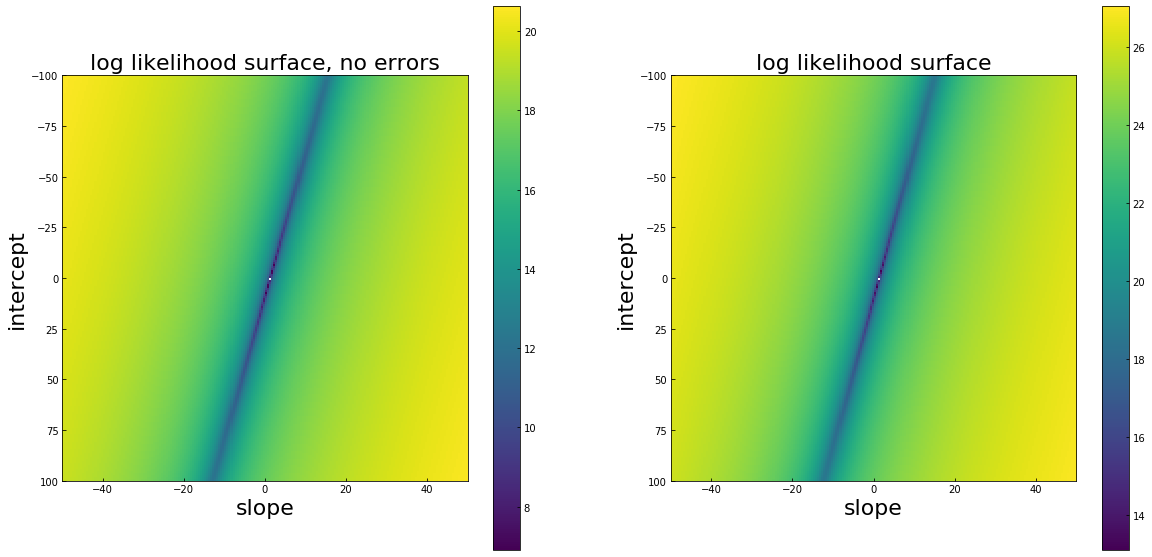

In [124]:
fig = pl.figure(figsize=(20,10))
ax1 = fig.add_subplot(121)
ax1.set_title ("log likelihood surface, no errors", fontsize = 22)
pl.imshow(np.log(resids_noerror), extent = [-50,50,100,-100], aspect=0.5)
ax1.set_xlabel('slope', fontsize = 22)
ax1.set_ylabel('intercept', fontsize = 22)
pl.colorbar()

ax2 = fig.add_subplot(122)
ax2.set_title ("log likelihood surface", fontsize = 22)
pl.imshow(np.log(resids), extent = [-50,50,100,-100], aspect=0.5)
ax2.set_xlabel('slope', fontsize = 22)
ax2.set_ylabel('intercept', fontsize = 22)
pl.colorbar();


Figure 11: ...

//anaconda/envs/GEOP/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
//anaconda/envs/GEOP/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in subtract
  after removing the cwd from sys.path.


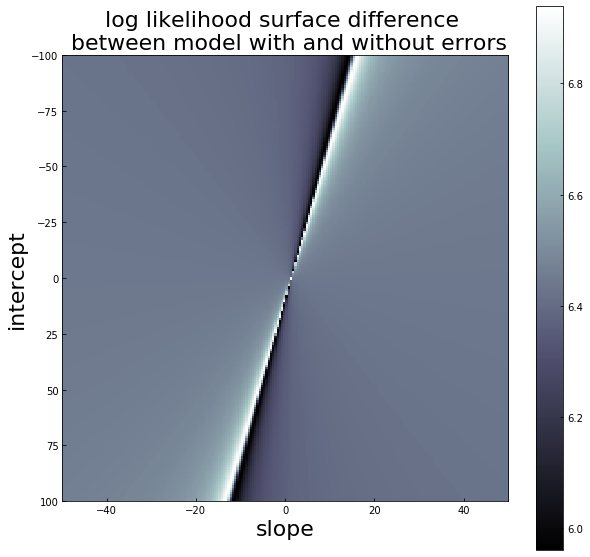

In [125]:
#leave
#plotting the difference between the 2 likelihood surfaces to see if the minimum is in the right place
ax1 = pl.figure(figsize=(10,10)).add_subplot(111)
ax1.set_title ("log likelihood surface difference \n between model with and without errors", fontsize = 22)
pl.imshow(np.abs(np.log(resids) - np.log(resids_noerror)), extent = [-50,50,100,-100], aspect=0.5, cmap='bone')
ax1.set_xlabel('slope', fontsize = 22)
ax1.set_ylabel('intercept', fontsize = 22)
pl.colorbar();


Figure 12: ...